 # **Homework III**

 ## **IMPORTANT NOTICE:** COMMENTS ARE BRIEF. FULL EXPLANATION IS AVAILABLE IN THE REPORT.

## Exercise 1.1

In [1]:
import networkx as nx
import numpy as np
#np.random.seed(13) 
import statistics
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import math

In [2]:
# Set paramters of epidemic
beta = 0.3 # probability of being infected
rho = 0.7 # probability of recovering
weeks = 15
simulations = 100
Io = 10 # number of infected at time t=0

In [3]:
# simulate SIR model

def SIR(G, N, beta, rho, weeks, Io):

  S, I, R = 0, 1, 2

  # Define an array that records the state of each node (S, I or V)
  states = np.zeros(N, dtype="int")

  # Define arrays to record number of individuals in each category per week
  susceptibles = np.zeros(weeks, dtype="int")
  infected = np.zeros(weeks, dtype="int")
  new_infected = np.zeros(weeks, dtype="int")
  recovered = np.zeros(weeks, dtype="int")

  # Randomly choose initial infected nodes
  seed = [np.random.choice(N-1, size = Io)]
  for s in seed:
    states[s] = I

  # for every week
  for j in range(weeks):

    #count number of individals in each category according to their state
    susceptibles[j] = len(np.where(states[:] == S)[0])
    infected[j] = len(np.where(states[:] == I)[0])
    recovered[j] = len(np.where(states[:] == R)[0])

    # reset number of new infected equal to 0 at the beginning of each week
    new_i = 0

    # new_states saves the current state of nodes and will be used to make updates (we cannot do it directly on states or we loose information of previous states)
    new_states=np.array(states)
    
    for i, state in enumerate(states):
      if state == S:
        neighbors = list(G.neighbors(i))
        infected_neighbors = 0

        # Count number of infected neighbors
        for n in neighbors:
          if states[n] == I:
            infected_neighbors += 1
        if infected_neighbors != 0:
          # define probability of being infected (S becoming I)
          p_i = 1-(1-beta)**infected_neighbors # probability of becoming infected
          choice = np.random.choice([S,I], p=[1-p_i, p_i])
          if choice == I: #susceptible becomes infected
            new_states[i] = I 
            new_i += 1
      else:
        if state == I: # state I
          # Decide if infected individual recoveres
          choice = np.random.choice([I,R], p=[1-rho, rho])
          if choice == R: #infected becomes recovered
            new_states[i] = R 
    
    # Update states according to changes
    states=np.array(new_states)

    # Update new infected
    new_infected[j] = new_i 

  return susceptibles, infected, recovered, new_infected

In [4]:
# Define function that perfomrms the SIR simulation a given number of times (simulations)

def run_SIR(G, N, beta, rho, Io,  weeks, simulations):

  S = np.zeros((simulations, weeks))
  I = np.zeros((simulations, weeks))
  R = np.zeros((simulations, weeks))
  new_I = np.zeros((simulations, weeks))

  for i in range(simulations):
    S[i, :], I[i, :], R[i, :], new_I[i, :] = SIR(G, N, beta, rho, weeks, Io)

  avg_S = np.average(S, axis=0)
  std_S = np.std(S, axis = 0)

  avg_I = np.average(I, axis=0)
  std_I = np.std(I, axis = 0)

  avg_R = np.average(R, axis=0)
  std_R = np.std(R, axis = 0)

  avg_new_I = np.average(new_I, axis=0)
  std_new_I = np.std(new_I, axis = 0)

  return avg_S, std_S, avg_I, std_I, avg_R, std_R, avg_new_I, std_new_I

In [5]:
# Plot S, I, R avg curves with standard deviation

def plot_SIR(avg_S, avg_I, avg_R, std_S, std_I, std_R, weeks, simulations):
  fig = plt.figure(figsize=(8,5), dpi=100)
  ax = plt.subplot(111)
  ax.plot(range(1,weeks+1), avg_S, 'go-', label="S")
  ax.fill_between(range(1,weeks+1), avg_S-std_S, avg_S+std_S, alpha=0.2,  facecolor='g')
  ax.plot(range(1,weeks+1), avg_I, 'ro-', label="I")
  ax.fill_between(range(1,weeks+1), avg_I-std_I, avg_I+std_I, alpha=0.2,  facecolor='r')
  ax.plot(range(1,weeks+1), avg_R, 'bo-', label="R")
  ax.fill_between(range(1,weeks+1), avg_R-std_R, avg_R+std_R, alpha=0.2,  facecolor='b')
  ax.set_title(f"SIR Model (average behaviour on {simulations} simulations)")
  ax.set_xlabel("Weeks")
  ax.set_ylabel("Number of Individulas")
  ax.legend()
  plt.show()


In [6]:
# plot new infected curve with standard deviation

def plot_new(avg, std, weeks, simulations, caption, color):
  fig = plt.figure(figsize=(8,5), dpi=100)
  ax = plt.subplot(111)
  ax.plot(range(1,weeks+1), avg, color, label = caption)
  ax.fill_between(range(1,weeks+1), avg-std, avg+std, alpha=0.2,  facecolor=color[0])
  ax.set_title(f"Average {caption} per week over {simulations} simulations")
  ax.set_xlim([0,weeks+1])
  ax.set_ylim([0, None])
  ax.set_xlabel("Weeks")
  ax.set_ylabel("Number of "+ caption)
  plt.legend(bbox_to_anchor=(1., 1.01))
  plt.show()

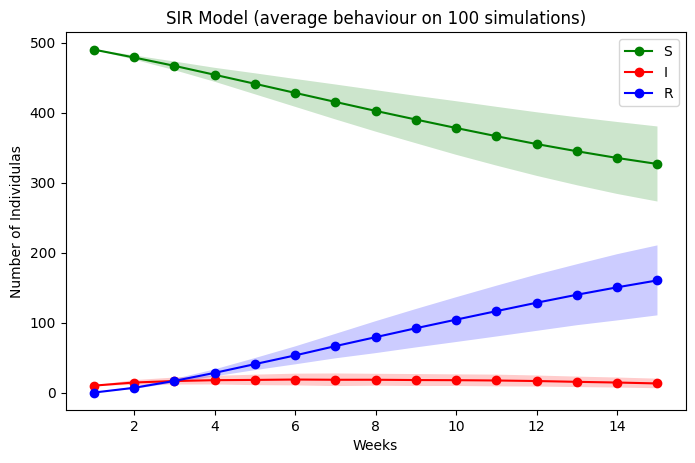

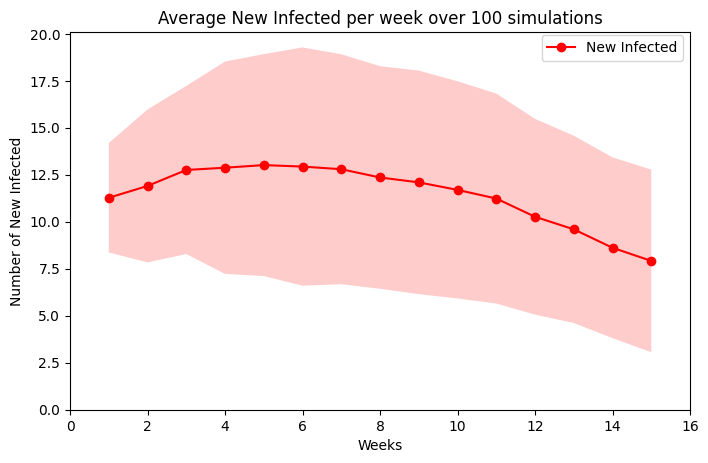

In [7]:
# Define Graph
N, k = 500, 4
G = nx.random_regular_graph(k, N , seed=None)

# Run epidemic
avg_S, std_S, avg_I, std_I, avg_R, std_R, avg_new_I, std_new_I = run_SIR(G, N, beta, rho, Io,  weeks, simulations)
plot_SIR(avg_S, avg_I, avg_R, std_S, std_I, std_R, weeks, simulations)
plot_new(avg_new_I, std_new_I, weeks, simulations, "New Infected", "ro-")

## Exercise 1.2

In [8]:
# Define algorithm for creation of graphs using preferential attachment 

def preferential_attachment(N, k):

  '''
  Define the graph G we start from (complete with k+1 nodes).
  Objective: obtain a final graph with n>k+1 nodes and average degree close to k. 
  To do this add one node at a time ensuring its degree is equal to c=k/2
  '''
  
  G = nx.complete_graph(k+1)
  #nx.draw(G, with_labels=True, node_color='orange')
  c = int(k/2)

  # Add one node at a time till I reach desired number on nodes
  for node in range(k+1,N):
      degrees = np.array([d for nod, d in G.degree()])
      probs = degrees/sum(degrees)
      if (k % 2) == 0:
        c=int(k/2)
      else:
        # manage case in which k is odd by alternating between floor and ceiling of k/2
        if (node % 2) == 0:
          c=math.floor(k/2)
        else:
          c=math.ceil(k/2)

      # define newighbors for the new node
      neighbors = np.random.choice(G.nodes(), p=probs, size=c, replace=False)
      G.add_node(node)

      # add edges from new ndoe to its selected nodes
      for neighbor in neighbors:
          G.add_edge(node,neighbor) 

  W = nx.adjacency_matrix(G).toarray()
  w = np.sum(W, axis=1)
  #print(f"Desired degree: {k}\nAverage degree: {round(np.mean(w),2)}")

  return G

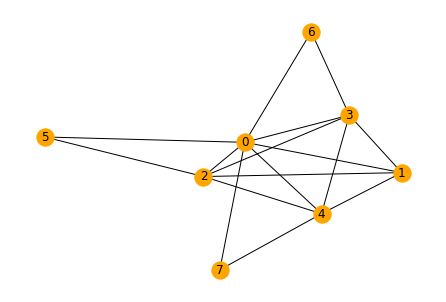

In [9]:
# Simple exmample of how it works
G = preferential_attachment(8, 4)
nx.draw(G, with_labels=True, node_color='orange')

## Exercise 2

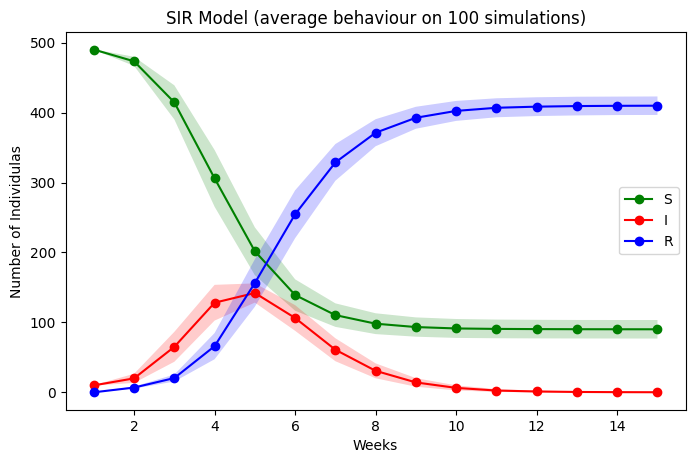

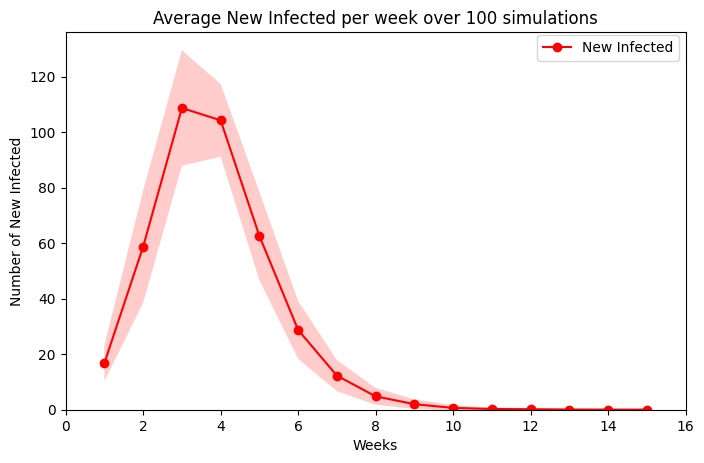

In [10]:
'''
We generate a graph using preferential attachment such that n=500 and k=6.
Hyperparameters are equal to the ones set initially
'''

N, k = 500, 6
G = preferential_attachment(N, k)
avg_S, std_S, avg_I, std_I, avg_R, std_R, avg_new_I, std_new_I = run_SIR(G, N, beta, rho, Io, weeks, simulations)
plot_SIR(avg_S, avg_I, avg_R, std_S, std_I, std_R, weeks, simulations)
plot_new(avg_new_I, std_new_I, weeks, simulations, "New Infected", "ro-")

## Exercise 3

In [11]:
def cumulativePerc_to_perWeek(V_cumulative_perc, N, weeks):

  '''
  The text of the problem gives us the cumulative percentages of vaccinated people per week
  This functions returns, given the total number of nodes N, the number of people that have to be vaccinated each week (not cumulative)
  '''

  V_cumulative = [int(N/100*el) for el in V_cumulative_perc]
  V_per_week = [0] * weeks 

  for i, el in enumerate(V_cumulative):
    if i == 0:
      before = el
      V_per_week[i] = before
    else:
      V_per_week[i]=int(el-before)
      before=el

  return V_per_week


In [12]:
# Define function for SIR model with vaccination (SIRV)
def SIRV(G, N, beta, rho, weeks, Io, V_per_week, I_real, simulations):
    
    '''
    List of lists for each compartment.
    For exampple S will contain a number of lists equal to the simulations argument passed (number of times to run the SIRV model)
    Each sublist will have a number of elements equal to weeks, i.e. for each week we report the number of susceptible individuals recorded.
    '''
    S, I, R, V = [], [], [], []
    new_I, new_V = [], []
  
    for j in range(simulations):
      # Define susceptible, infected, recovered, vaccinated, potential candidates for vaccination sets
      i = set(np.random.choice(G.nodes, size = Io, replace = False))
      r = set()
      s =  set(G.nodes) - set(i) - set(r)
      v = set() 
      potential_V = set(G.nodes) 
      
      if I_real != []:
        new_I.append(I_real[0]) 
        stop = weeks - 1
      else:
        stop = weeks
      
      for idx in range(stop):
        new_i = []
        new_r = []

        # Identify individuals that should receive the vaccination
        n_vaccinated = V_per_week[idx] if V_per_week[idx]<=len(potential_V) else len(potential_V)
        new_v =  np.random.choice(list(potential_V), size = n_vaccinated, replace = False) 
        
        # Update sets
        s = set(s) - set(new_v) 
        i = set(i) - set(new_v)
        v = set(v).union(set(new_v))

        # Determine if a susceptible becomes infected according to transition probability 1-(1-beta)^m, with m being the number of infected nodes
        for el in s:
          neighbors = G.neighbors(el)
          m = len(list(set(i).intersection(neighbors)))
          prob = 1-(1-beta)**m
          
          choice = np.random.choice(2, p=[prob, 1 - prob])
          if choice == 0:
            new_i.append(el)
        
        # Determine if an infected individual should recover 
        for el in i:
          choice = np.random.choice(2, p=[rho, 1 - rho])
          if choice == 0:
            new_r.append(el)

        # Append results to global variables for each category
        new_I.append(len(new_i))
        new_V.append(len(new_v))
        I.append(len(i))
        R.append(len(r))
        S.append(len(s))
        V.append(len(v))

        i = i.union(set(new_i)) - set(new_r) 
        r = r.union(set(new_r))
        s =  set(s) - set(new_i)
        potential_V = set(potential_V) - set(r) - set(new_v) 

    # If we are given I_real (the true number of new infected) we compute the loss
    if I_real!=[]:
      avg_new_I = np.array(np.mean(np.reshape(new_I, (simulations,stop+1)), axis = 0), dtype=int)
      std_new_I = np.array(np.std(np.reshape(new_I, (simulations,stop+1)), axis = 0), dtype=int)
      loss  = np.sqrt(1/15* np.sum((avg_new_I - I_real)**2))
    else:
      avg_new_I = np.array(np.mean(np.reshape(new_I, (simulations,stop)), axis = 0), dtype=int)
      std_new_I = np.array(np.std(np.reshape(new_I, (simulations,stop)), axis = 0), dtype=int)
      loss = -1

    # Compute averages and standard deviations for each compartment over the number of simulations
    avg_S = np.array(np.mean(np.reshape(S, (simulations,stop)), axis = 0), dtype=int)
    std_S = np.array(np.std(np.reshape(S, (simulations,stop)), axis = 0),dtype=int)
    avg_I = np.array(np.mean(np.reshape(I, (simulations,stop)), axis = 0), dtype=int)
    std_I = np.array(np.std(np.reshape(I, (simulations,stop)), axis = 0),dtype=int)
    avg_R = np.array(np.mean(np.reshape(R, (simulations,stop)), axis = 0), dtype=int)
    std_R = np.array(np.std(np.reshape(R, (simulations,stop)), axis = 0), dtype=int)
    avg_V = np.array(np.mean(np.reshape(V, (simulations,stop)), axis = 0), dtype=int)
    std_V = np.array(np.std(np.reshape(V, (simulations,stop)), axis = 0), dtype=int)
    avg_new_V = np.array(np.mean(np.reshape(new_V, (simulations,stop)), axis = 0), dtype=int)
    std_new_V = np.array(np.std(np.reshape(new_V, (simulations,stop)), axis = 0), dtype=int)

    return avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V, std_S, std_I, std_R, std_V, std_new_I, std_new_V, loss
    

In [13]:
# Function to plot the SIRV model
def plot_SIRV(avg_S, avg_I, avg_R, avg_V, std_S, std_I, std_R, std_V, weeks, simulations):
  fig = plt.figure(figsize=(8,5), dpi=100)
  ax = plt.subplot(111)
  ax.plot(range(1,weeks+1), avg_S, 'go-', label="S")
  ax.fill_between(range(1,weeks+1), avg_S-std_S, avg_S+std_S, alpha=0.2,  facecolor='g')
  ax.plot(range(1,weeks+1), avg_I, 'ro-', label="I")
  ax.fill_between(range(1,weeks+1), avg_I-std_I, avg_I+std_I, alpha=0.2,  facecolor='r')
  ax.plot(range(1,weeks+1), avg_R, 'bo-', label="R")
  ax.fill_between(range(1,weeks+1), avg_R-std_R, avg_R+std_R, alpha=0.2,  facecolor='b')
  ax.plot(range(1,weeks+1), avg_V, 'ko-', label="V")
  ax.fill_between(range(1,weeks+1), avg_V-std_V, avg_V+std_V, alpha=0.2,  facecolor='k')
  ax.set_title(f"SIR Model with vaccination (average behaviour on {simulations} simulations)")
  ax.set_xlabel("Weeks")
  ax.set_ylabel("Number of Individulas")
  ax.set_xlim([0,weeks+1])
  ax.legend()
  plt.show()

In [14]:
# Function to plot comparison of 
def plot_comparison(array1, std1, label1, color1, array2, std2, label2, color2, weeks, simulations, title):
  fig = plt.figure(figsize=(8,5), dpi=100)
  ax = plt.subplot(111)
  ax.plot(range(1,weeks+1), array1, color1, label=label1)
  ax.fill_between(range(1,weeks+1), array1-std1, array1+std1, alpha=0.2,  facecolor=color1[0])
  ax.plot(range(1,weeks+1), array2, color2, label=label2)
  ax.fill_between(range(1,weeks+1), array2-std2, array2+std2, alpha=0.2,  facecolor=color2[0])
  ax.set_title(f"{title} over {simulations} simulations")
  ax.set_xlabel("Weeks")
  ax.set_ylabel("Number of Individuals")
  ax.set_xlim([0,weeks+1])
  plt.legend(bbox_to_anchor=(1., 1.01))
  plt.show()


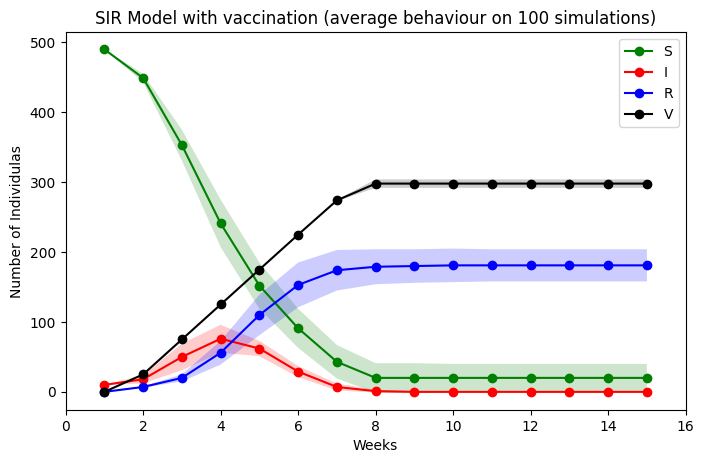

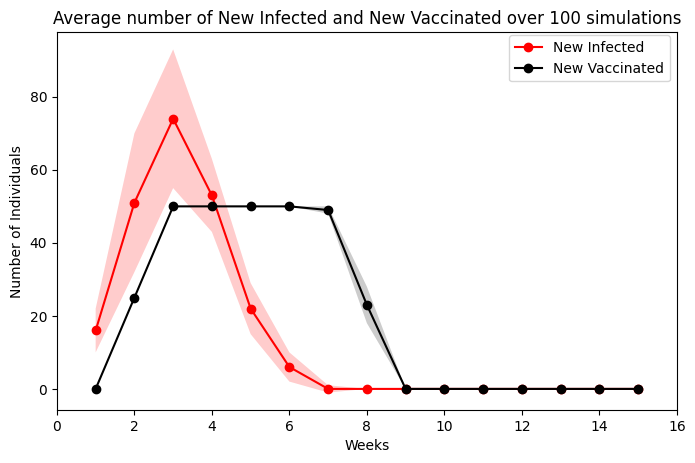

In [15]:
# Simulate the epidemic WITH PANDEMIC (we use the same parameters as before [beta=0.3, rho=0.6] so as to see the effect of vaccination on the dynamics) 
V_cumulative_perc = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
V_per_week = cumulativePerc_to_perWeek(V_cumulative_perc, N, weeks)
avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V, std_S, std_I, std_R, std_V, std_new_I, std_new_V, loss = SIRV(G, N, beta, rho, weeks, Io, V_per_week, [], simulations)
plot_SIRV(avg_S, avg_I, avg_R, avg_V, std_S, std_I, std_R, std_V, weeks, simulations)
plot_comparison(avg_new_I, std_new_I, "New Infected", 'ro-', avg_new_V, std_new_V, "New Vaccinated", 'ko-', weeks, simulations, "Average number of New Infected and New Vaccinated")

## Exercise 4

In [16]:
'''
Given the data of newly infected for the Swedish epidemic of swine flue we try
and find the parameters beta, rho and k that best describe the epidemic
'''
def grid_search(N, k, dk, beta, db, rho, dr, weeks, Io, V_per_week, I_real, simulations):

  # set an initial (high) value for the loss and define counters and boolean values for exit condition
  old_loss = 100
  stop = False
  count=0
  print("Currently using Preferential attachment model...")

  while stop==False:
    count+=1
    info = []
    # Define the grid with parameters to explore
    ks = [k - dk , k, k + dk]
    betas = [beta - db if beta - db >= 0 else 0, beta, beta + db if beta + db <=1 else 1]
    rhos = [rho - dr if rho - dr >= 0 else 0, rho, rho + dr if rho + dr <= 1 else 1 ]
    
    # For each combination of parameters (k,beta,rho) generate the graph, simulate the epidemic and calculate the loss
    for k in ks:
      G = preferential_attachment(N, k)
      for beta in betas:
        for rho in rhos:
          avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V, std_S, std_I, std_R, std_V, std_new_I, std_new_V, loss = SIRV(G, N, beta, rho, weeks, Io, V_per_week, I_real, simulations)
          info.append([loss, avg_new_I, k, beta, rho])

    # Take the combination which yields the best loss (i.e. the lowest)
    info.sort( key = lambda x: x[0])
    best_loss, best_avg_new_I, best_k, best_beta, best_rho = info[0]
    best_loss = round(best_loss, 2)

    # If the optimal parameters have remained invaried or the loss has not improved --> exit
    if (best_loss > old_loss) or (best_k == ks[1] and best_beta == betas[1] and best_rho == rhos[1]):
      print(f"Loss increased, previous combination was preferable.\nBest (previous) combination: k = {ks[1]}, beta = {round(betas[1],2)}, rho = {round(rhos[1],2)} with loss = {old_loss}")
      stop = True
      return ks[1], betas[1], rhos[1], old_loss, old_avg_new_I
    # If there has been an improvement (i.e. new loss is lower than previous) update starting values of k, beta and rho
    else:
      old_loss = round(best_loss, 2)
      old_avg_new_I = best_avg_new_I
      print(f"Loss at iteration {count}: {old_loss}")
      if(best_k != ks[1]):
        k = best_k
      # For beta and rho half the step sizes db and dk (i.e. as the algorithm progresses I explore smaller neighborhoods of the current best solution)
      if(best_beta != betas[1]):
        beta = best_beta
        db /=2 
      if(best_rho != rhos[1]):
        rho = best_rho
        dr /= 2 

Currently using Preferential attachment model...
Loss at iteration 1: 19.72
Loss at iteration 2: 4.31
Loss increased, previous combination was preferable.
Best (previous) combination: k = 13, beta = 0.15, rho = 0.6 with loss = 4.31
Currently using Preferential attachment model...
Loss at iteration 1: 9.21
Loss at iteration 2: 7.24
Loss at iteration 3: 3.79
Loss increased, previous combination was preferable.
Best (previous) combination: k = 12, beta = 0.17, rho = 0.8 with loss = 3.79
Currently using Preferential attachment model...
Loss at iteration 1: 15.78
Loss at iteration 2: 5.51
Loss at iteration 3: 4.21
Loss at iteration 4: 3.37
Loss increased, previous combination was preferable.
Best (previous) combination: k = 11, beta = 0.14, rho = 0.49 with loss = 3.37
Currently using Preferential attachment model...
Loss at iteration 1: 13.94
Loss at iteration 2: 6.57
Loss at iteration 3: 5.66
Loss increased, previous combination was preferable.
Best (previous) combination: k = 12, beta = 0

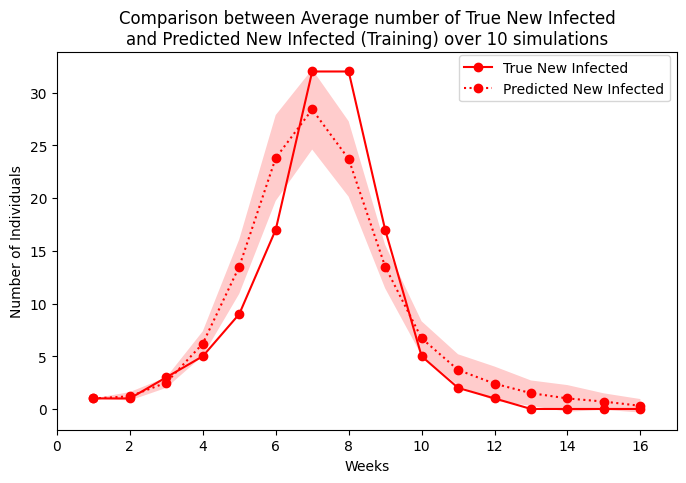

In [17]:
# Run grid search and find best parameters
N = 934
k, dk = 13, 1
beta, db = 0.3, 0.1
rho, dr = 0.6, 0.1
weeks = 16
Io = 1
I_real = np.array([1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0, 0])
simulations = 10

V_cumulative_perc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
V_per_week = cumulativePerc_to_perWeek(V_cumulative_perc, N, weeks)

ks, betas, rhos, losses, avg_I = [], [], [], [], []
iterations = 10
# We consider 10 different iterations to get more robust results
for idx in range(iterations):
  result = grid_search(N, k, dk, beta, db, rho, dr, weeks, Io, V_per_week, I_real, simulations)
  ks.append(result[0])
  betas.append(result[1])
  rhos.append(result[2])
  losses.append(result[3])
  avg_I.append(result[4])

# Compute averages
avg_ks, avg_betas, avg_rhos, avg_losses, std_losses, avg_avg_I, std_std_I = statistics.mean(ks), statistics.mean(betas), statistics.mean(rhos), statistics.mean(losses), statistics.stdev(losses), np.mean(avg_I, axis=0), np.std(avg_I,axis=0)
# Return optimal parameters and training loss
print(f"Over {simulations} simulations we have on average k= {round(avg_ks,2)}, beta={round(avg_betas,2)}, rho={round(avg_rhos,2)} with a loss of {round(avg_losses,2)} +/- {round(std_losses,2)}")
# Plot comparison of true new infected and predicted (during grid search)
plot_comparison(I_real, [0]*weeks, "True New Infected", 'ro-', avg_avg_I, std_std_I, "Predicted New Infected", 'ro:', weeks, simulations, "Comparison between Average number of True New Infected\nand Predicted New Infected (Training)")

Training Loss: 3.882, Validation loss: 7.726926513233975


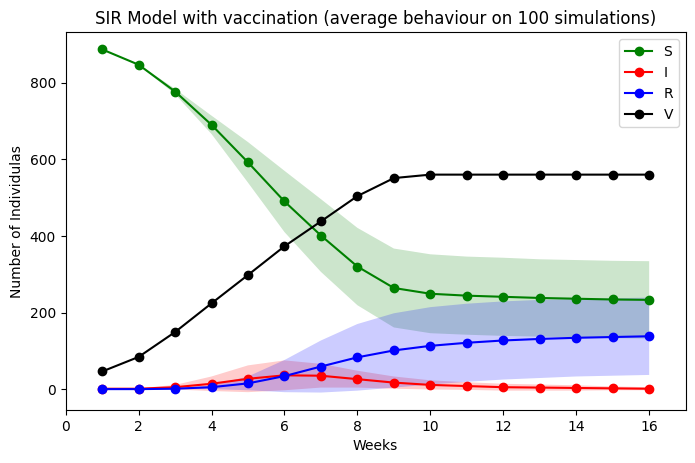

In [18]:
# Show trend of the epidemic with optimal results
simulations = 100
iterations = 20
avg = 0
for idx in range(iterations):
  G=preferential_attachment(N,int(round(avg_ks,0)))
  _, _, _, _, _, _, _, _, _, _, _, _, loss = SIRV(G, N, avg_betas, avg_rhos, weeks, Io, V_per_week, I_real, simulations)
  avg += loss

# Define difference between training loss and validation loss
print(f"Training Loss: {avg_losses}, Validation loss: {avg/iterations}")

G=preferential_attachment(N,int(round(avg_ks,0)))
avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V, std_S, std_I, std_R, std_V, std_new_I, std_new_V, loss = SIRV(G, N, avg_betas, avg_rhos, weeks, Io, V_per_week, [], simulations)
plot_SIRV(avg_S, avg_I, avg_R, avg_V, std_S, std_I, std_R, std_V, weeks, simulations)

## Exercise 5

In [19]:
'''
We try and improve on point 4 by using the Holme and Kim algorithm for growing graphs with 
powerlawdegree distribution and approximate average clustering. To do so we redefine the grid_search 
algorithm since an extra parameter needs to be optimized
'''

def grid_search(N, k, dk, beta, db, rho, dr, p, dp, weeks, Io, V_per_week, I_real, simulations):

  old_loss = 100
  stop = False
  count=0
  print("Currently using Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering....")

  while stop==False:
    count+=1
    info = []
    ks = [k - dk , k, k + dk]
    betas = [beta - db if beta - db >= 0 else 0, beta, beta + db if beta + db <=1 else 1]
    rhos = [rho - dr if rho - dr >= 0 else 0, rho, rho + dr if rho + dr <= 1 else 1 ]
    probs = [p - dp if p - dp >= 0 else 0, p, p + dp if p + dp <= 1 else 1]
    
    for k in ks:
      for beta in betas:
        for rho in rhos:
          for p in probs: 
            G = nx.powerlaw_cluster_graph(N, k, p, seed=None)
            avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V, std_S, std_I, std_R, std_V, std_new_I, std_new_V, loss = SIRV(G, N, beta, rho, weeks, Io, V_per_week, I_real, simulations)
            info.append([loss, avg_new_I, k, beta, rho, p])

    info.sort( key = lambda x: x[0])
    best_loss, best_avg_new_I, best_k, best_beta, best_rho, best_p = info[0]
    best_loss = round(best_loss, 2)
  
    if(best_k == ks[1] and best_beta == betas[1] and best_rho == rhos[1] and best_p == probs[1]): 
      print(f"Parameters remained invaried.\nBest combination: k = {best_k}, beta = {round(best_beta,2)}, rho = {round(best_rho,2)}, p={round(best_p,2)} with loss = {best_loss}")
      stop = True
      return best_k, best_beta, best_rho, best_p, best_loss, best_avg_new_I
    elif best_loss > old_loss:
      print(f"Loss increased, previous combination was preferable.\nBest (previous) combination: k = {ks[1]}, beta = {round(betas[1],2)}, rho = {round(rhos[1],2)}, p = {round(probs[1],2)} with loss = {old_loss}")
      stop = True
      return ks[1], betas[1], rhos[1], probs[1], old_loss, old_avg_new_I
    else:
      old_loss = round(best_loss, 2)
      old_avg_new_I = best_avg_new_I
      print(f"Loss at iteration {count}: {old_loss}")
      if(best_k != ks[1]):
        k = best_k
        dk = int(dk /2) # diminish step size
      if(best_beta != betas[1]):
        beta = best_beta
        db /=2 #diminish step size
      if(best_rho != rhos[1]):
        rho = best_rho
        dr /= 2 #diminish step size
      if(best_p != probs[1]):
        p = best_p
        dp /= 2 #diminish step size

Currently using Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering....
Loss at iteration 1: 3.65
Loss increased, previous combination was preferable.
Best (previous) combination: k = 3, beta = 0.3, rho = 0.5, p = 0.5 with loss = 3.65
Currently using Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering....
Loss at iteration 1: 4.69
Loss increased, previous combination was preferable.
Best (previous) combination: k = 5, beta = 0.3, rho = 0.7, p = 0.5 with loss = 4.69
Currently using Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering....
Loss at iteration 1: 5.54
Loss at iteration 2: 3.37
Loss increased, previous combination was preferable.
Best (previous) combination: k = 3, beta = 0.35, rho = 0.65, p = 0.6 with loss = 3.37
Currently using Holme and Kim algorithm for growing graphs with powerlaw degree distrib

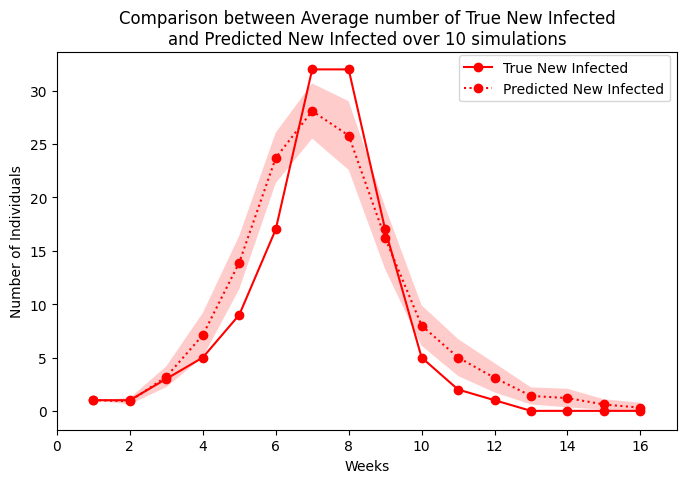

In [20]:
N = 934
k, dk = 4, 1
beta, db = 0.2, 0.1
rho, dr = 0.6, 0.1
p, dp = 0.4, 0.1
weeks = 16
Io = 1
I_real = np.array([1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0, 0])
simulations = 10

V_cumulative_perc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
V_per_week = cumulativePerc_to_perWeek(V_cumulative_perc, N, weeks)

ks, betas, rhos, probs, losses, avg_I = [], [], [], [], [], []
iterations = 10
for idx in range(iterations):
  result = grid_search(N, k, dk, beta, db, rho, dr, p, dp, weeks, Io, V_per_week, I_real, simulations)
  ks.append(result[0])
  betas.append(result[1])
  rhos.append(result[2])
  probs.append(result[3])
  losses.append(result[4])
  avg_I.append(result[5])

avg_ks, avg_betas, avg_rhos, avg_probs, avg_losses, std_losses, avg_avg_I, std_std_I = round(statistics.mean(ks), 0), statistics.mean(betas), statistics.mean(rhos), statistics.mean(probs), statistics.mean(losses), statistics.stdev(losses), np.mean(avg_I, axis=0), np.std(avg_I,axis=0)
print(f"Over {simulations} simulations we have on average k= {round(avg_ks,2)}, beta={round(avg_betas,2)}, rho={round(avg_rhos,2)}, p={round(avg_probs,2)} with a loss of {round(avg_losses,2)} +/- {round(std_losses,2)}")
plot_comparison(I_real, [0]*weeks, "True New Infected", 'ro-', avg_avg_I, std_std_I, "Predicted New Infected", 'ro:', weeks, simulations, "Comparison between Average number of True New Infected\nand Predicted New Infected")

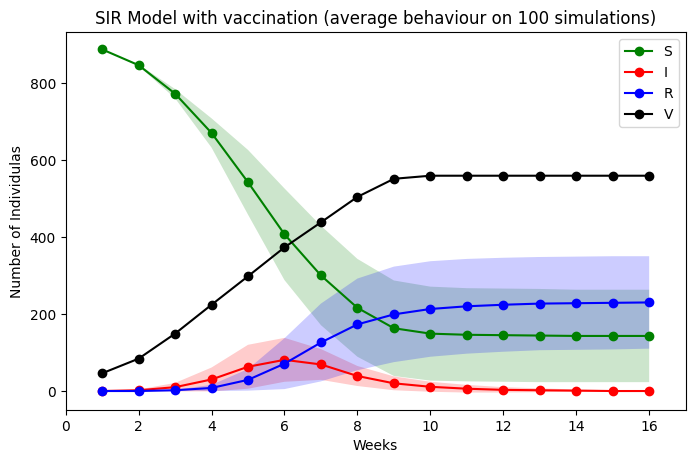

In [24]:
simulations = 100
G = nx.powerlaw_cluster_graph(N, int(round(avg_ks,0)), avg_probs, seed=None)
avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V, std_S, std_I, std_R, std_V, std_new_I, std_new_V, loss = SIRV(G, N, avg_betas, avg_rhos, weeks, Io, V_per_week, [], simulations)
plot_SIRV(avg_S, avg_I, avg_R, avg_V, std_S, std_I, std_R, std_V, weeks, simulations)